In [288]:
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.image as img
import seaborn as sns

import numpy as np
import pandas as pd

import pickle

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split, KFold, GridSearchCV, cross_val_score

from lightgbm import LGBMRegressor

from sklearn.metrics import mean_squared_error as mse, r2_score as r2

%matplotlib inline

In [289]:
df = pd.read_csv('/Users/1/Desktop/realestatepriceprediction/train.csv', sep=',')

X = df.drop('Price', axis=1)
y = df[['Price']]

X_final = pd.read_csv('/Users/1/Desktop/realestatepriceprediction/test.csv', sep=',')

preds_final = pd.DataFrame()
preds_final['Id'] = X_final['Id'].copy()

X.set_index('Id', inplace=True)
X_final.set_index('Id', inplace=True)


#### Data fields
Id - идентификационный номер квартиры

DistrictId - идентификационный номер района

Rooms - количество комнат

Square - площадь

LifeSquare - жилая площадь

KitchenSquare - площадь кухни

Floor - этаж

HouseFloor - количество этажей в доме

HouseYear - год постройки дома

Ecology_1, Ecology_2, Ecology_3 - экологические показатели местности

Social_1, Social_2, Social_3 - социальные показатели местности

Healthcare_1, Helthcare_2 - показатели местности, связанные с охраной здоровья

Shops_1, Shops_2 - показатели, связанные с наличием магазинов, торговых центров

Price - цена квартиры

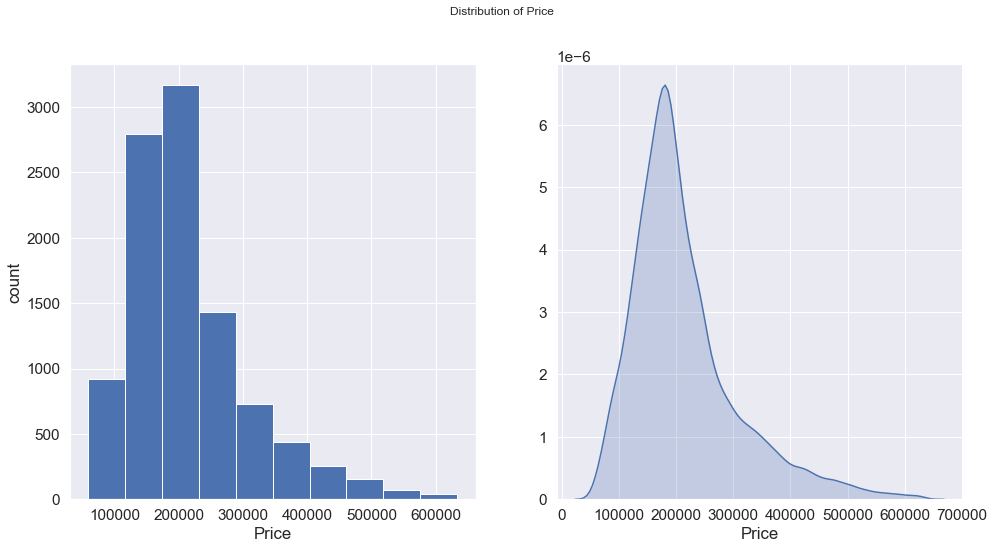

In [290]:
plt.figure(figsize = (16, 8))

plt.subplot(121)
df['Price'].hist()
plt.ylabel('count')
plt.xlabel('Price')

plt.subplot(122)
sns.kdeplot(train['Price'], shade=True, legend=False)
plt.xlabel('Price')

plt.suptitle('Distribution of Price')
plt.show()

In [291]:
X.dtypes

DistrictId         int64
Rooms            float64
Square           float64
LifeSquare       float64
KitchenSquare    float64
Floor              int64
HouseFloor       float64
HouseYear          int64
Ecology_1        float64
Ecology_2         object
Ecology_3         object
Social_1           int64
Social_2           int64
Social_3           int64
Healthcare_1     float64
Helthcare_2        int64
Shops_1            int64
Shops_2           object
dtype: object

In [292]:
X['Ecology_2'].value_counts()

B    9903
A      97
Name: Ecology_2, dtype: int64

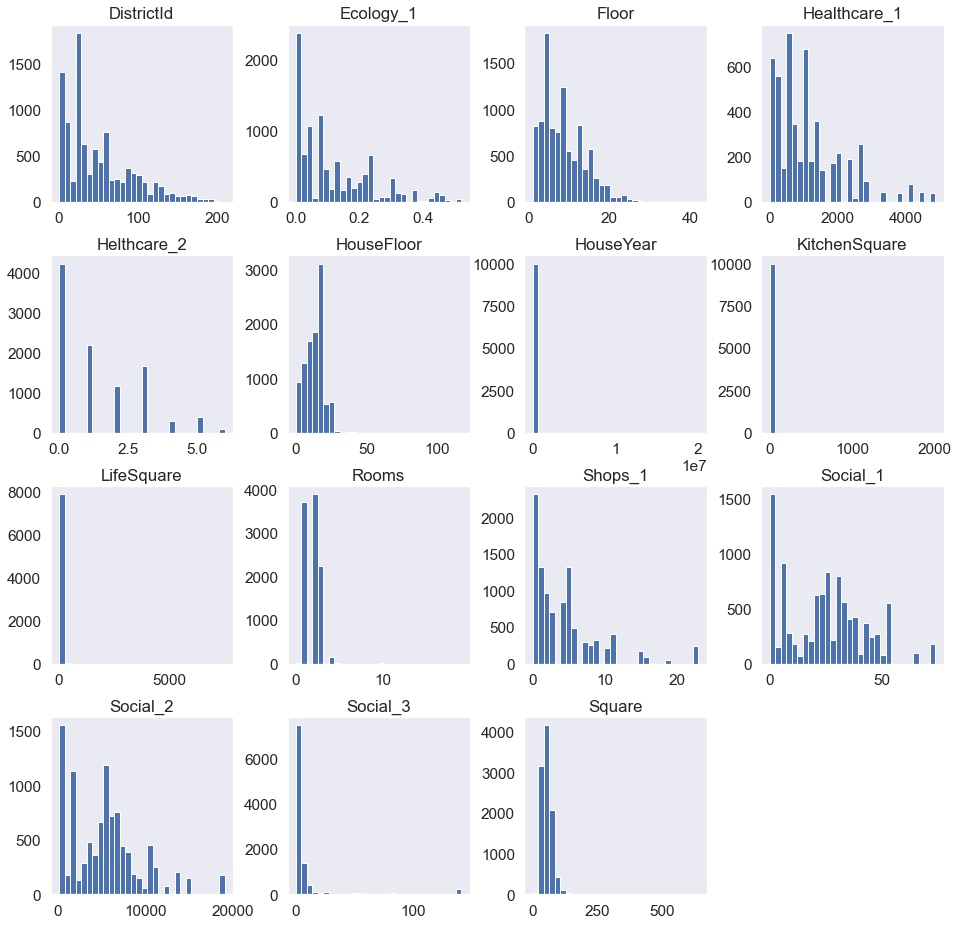

In [293]:
X.hist(figsize=(16, 16), bins=30, grid=False);

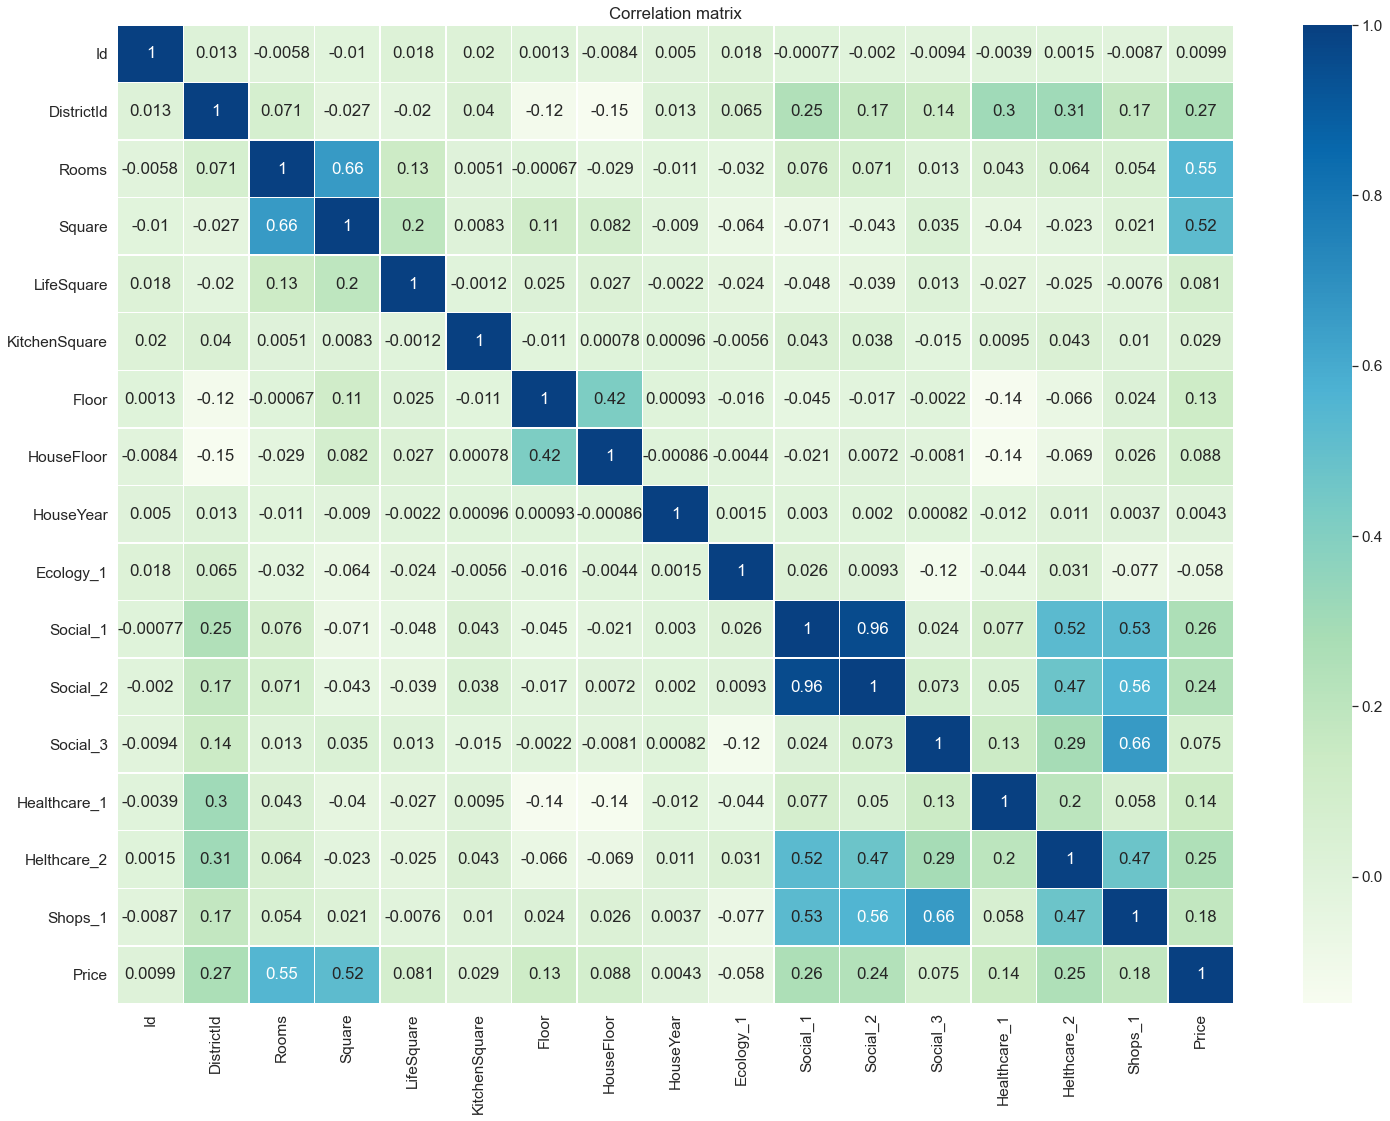

In [294]:
plt.figure(figsize = (25,18))

sns.set(font_scale=1.4)
sns.heatmap(df.corr(), annot=True, linewidths=.4, cmap='GnBu')

plt.title('Correlation matrix')
plt.show()

In [295]:
X.columns.tolist()

['DistrictId',
 'Rooms',
 'Square',
 'LifeSquare',
 'KitchenSquare',
 'Floor',
 'HouseFloor',
 'HouseYear',
 'Ecology_1',
 'Ecology_2',
 'Ecology_3',
 'Social_1',
 'Social_2',
 'Social_3',
 'Healthcare_1',
 'Helthcare_2',
 'Shops_1',
 'Shops_2']

In [296]:
X['HouseYear'].sort_values().unique()

array([    1910,     1912,     1914,     1916,     1917,     1918,
           1919,     1928,     1929,     1930,     1931,     1932,
           1933,     1934,     1935,     1936,     1937,     1938,
           1939,     1940,     1941,     1942,     1947,     1948,
           1950,     1951,     1952,     1953,     1954,     1955,
           1956,     1957,     1958,     1959,     1960,     1961,
           1962,     1963,     1964,     1965,     1966,     1967,
           1968,     1969,     1970,     1971,     1972,     1973,
           1974,     1975,     1976,     1977,     1978,     1979,
           1980,     1981,     1982,     1983,     1984,     1985,
           1986,     1987,     1988,     1989,     1990,     1991,
           1992,     1993,     1994,     1995,     1996,     1997,
           1998,     1999,     2000,     2001,     2002,     2003,
           2004,     2005,     2006,     2007,     2008,     2009,
           2010,     2011,     2012,     2013,     2014,     2

In [297]:
X['Rooms'].value_counts()

2.0     3880
1.0     3705
3.0     2235
4.0      150
5.0       18
0.0        8
10.0       2
19.0       1
6.0        1
Name: Rooms, dtype: int64

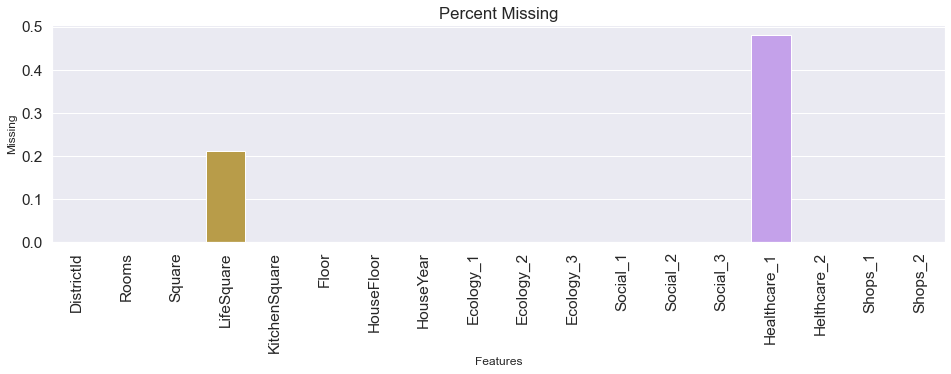

In [298]:
import seaborn as sns

nan_df = (X.isna().sum() / X.shape[0]).reset_index()
nan_df.columns=['feature', 'nan_percent']

plt.figure(figsize=(16,4))
sns.barplot(nan_df['feature'], nan_df['nan_percent'])
plt.title('Percent Missing')
plt.ylabel('Missing', fontsize=12)
plt.xlabel('Features', fontsize=12)
plt.xticks(rotation=90)
plt.show()

In [299]:
class FeatureImputer:
    
    def __init__(self):
        self.medians=None
        
    def fit(self, X):
        self.medians = X.median()
    
    def transform(self, X):
        
        # Rooms
        X['Rooms_outlier'] = 0
        X.loc[(X['Rooms'] == 0) | (X['Rooms'] >= 6), 'Rooms_outlier'] = 1
        
        X.loc[X['Rooms'] == 0, 'Rooms'] = 1
        X.loc[X['Rooms'] >= 6, 'Rooms'] = self.medians['Rooms'] # !!! медиана посчитана на трейне !!!
        
        # KitchenSquare
        X.loc[X['KitchenSquare'] < 3, 'KitchenSquare'] = 3
        X.loc[X['KitchenSquare'] > 500, 'KitchenSquare'] = self.medians['KitchenSquare']
        
        # HouseFloor, Floor
        
        X.loc[X['HouseFloor'] == 0, 'HouseFloor'] = self.medians['HouseFloor']
        X.loc[X['Floor'] > X['HouseFloor'], 'Floor'] = X.loc[X['Floor'] > X['HouseFloor'], 'HouseFloor']
        
        # HouseYear
        if 'HouseYear' in X.columns:
            X.drop('HouseYear', axis=1, inplace=True)
            
        
        # Healthcare_1
        if 'Healthcare_1' in X.columns:
            X.drop('Healthcare_1', axis=1, inplace=True)
            
        # LifeSquare
        X['LifeSquare_nan'] = X['LifeSquare'].isna() * 1
        
        condition = (X['LifeSquare'].isna()) &\
                      (~X['Square'].isna()) & \
                      (~X['KitchenSquare'].isna())
        
        X.loc[condition, 'LifeSquare'] = X.loc[condition, 'Square'] - X.loc[condition, 'KitchenSquare'] - 3
        
        
        return X
        

In [300]:
imputer = FeatureImputer()

imputer.fit(X) 

X = imputer.transform(X)
X_final = imputer.transform(X_final)

In [301]:
X.columns.tolist()

['DistrictId',
 'Rooms',
 'Square',
 'LifeSquare',
 'KitchenSquare',
 'Floor',
 'HouseFloor',
 'Ecology_1',
 'Ecology_2',
 'Ecology_3',
 'Social_1',
 'Social_2',
 'Social_3',
 'Helthcare_2',
 'Shops_1',
 'Shops_2',
 'Rooms_outlier',
 'HouseFloor_outlier',
 'LifeSquare_nan']

In [302]:
X.dtypes

DistrictId              int64
Rooms                 float64
Square                float64
LifeSquare            float64
KitchenSquare         float64
Floor                 float64
HouseFloor            float64
Ecology_1             float64
Ecology_2              object
Ecology_3              object
Social_1                int64
Social_2                int64
Social_3                int64
Helthcare_2             int64
Shops_1                 int64
Shops_2                object
Rooms_outlier           int64
HouseFloor_outlier      int64
LifeSquare_nan          int32
dtype: object

In [303]:
def str_to_int_map(string, mapping):

   return int(''.join([str(mapping.get(x, x)) for x in string]))
mapping = {"A": 1, "B": 2}
X['Ecology_2'] = X['Ecology_2'].apply(lambda x: str_to_int_map(x, mapping))

In [304]:
def str_to_int_map(string, mapping):

   return int(''.join([str(mapping.get(x, x)) for x in string]))
mapping = {"A": 1, "B": 2}
X_final['Ecology_2'] = X_final['Ecology_2'].apply(lambda x: str_to_int_map(x, mapping))

In [305]:
X['Ecology_3'] = X['Ecology_3'].apply(lambda x: str_to_int_map(x, mapping))

In [306]:
X_final['Ecology_3'] = X_final['Ecology_3'].apply(lambda x: str_to_int_map(x, mapping))

In [307]:
X['Shops_2'] = X['Shops_2'].apply(lambda x: str_to_int_map(x, mapping))

In [308]:
X_final['Shops_2'] = X_final['Shops_2'].apply(lambda x: str_to_int_map(x, mapping))

In [309]:
X['Shops_2'].value_counts()


2    9175
1     825
Name: Shops_2, dtype: int64

In [310]:
model = RandomForestRegressor(n_estimators=1000, max_depth=12, random_state=42)

In [ ]:
model.fit(X, y.values[:, 0])

In [287]:
y_pred_final = model.predict(X_final)

preds_final['Price'] = y_pred_final
preds_final


NotFittedError: This RandomForestRegressor instance is not fitted yet. Call 'fit' with appropriate arguments before using this estimator.

In [255]:
preds_final.to_csv('/Users/1/Desktop/realestatepriceprediction/predictions.csv', index=False)